<a href="https://colab.research.google.com/github/FERMEN23/CNN/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importar Libreria**

In [1]:
import torch

##**Comprobar el dispositivo Disponible**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

##**Descargar la Base de Datos MNIST**

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [7]:
print(train_data.targets.size())

torch.Size([60000])


**Imprimir un objeto de la data de entrenamiento train_data**

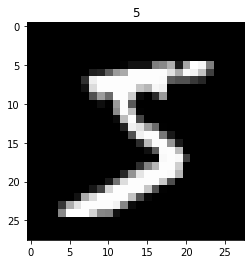

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.savefig('Ejemplo.eps', format='eps')
plt.show()


**Imprimir algunos elementos aleatorios de la data de prueba** 

La línea que está comentada y un cambio en la linea 

img, label = test_data[i] 

por 

img, label = test_data[sample_idx]
Hace una impresión aleatoria de los datos de pueba en la base de datos

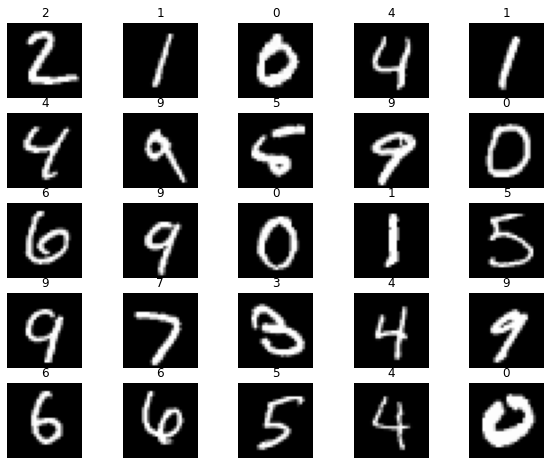

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = test_data[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

##**Preparación de datos para el entrenamiento con DataLoaders**

In [10]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fbf99e5ac90>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fbf99e5a650>}

##**Definir el modelo de red neuronal convolucional**

In [11]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [12]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


##**Definir función de pérdida**

In [ ]:
loss_func = nn.CrossEntropyLoss()   
loss_func

##**Definir una función de optimización**

In [ ]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

##**Entrenar el modelo**  

**Función de entrenamiento: train()**

In [ ]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

##**Evaluar el modelo en los datos de prueba**

In [118]:
prediccion=[]
correcto=[]
media=[]
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            #print("lbs",labels)
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            temp=pred_y.data.numpy().squeeze()
            prediccion.append(temp)
            temp2=labels.numpy().squeeze()
            correcto.append(temp2)
            #accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            #media.append(accuracy)
            pass
        #accuracy=statistics.mean(media)
        #print('Exactitud de prueba del modelo en las 10000 imágenes de prueba: %.2f' % accuracy)
        pass
test()


              precision    recall  f1-score   support

           0      0.992     0.992     0.992       980
           1      0.985     0.996     0.990      1135
           2      0.986     0.993     0.989      1032
           3      0.995     0.977     0.986      1010
           4      0.989     0.987     0.988       982
           5      0.977     0.987     0.982       892
           6      0.987     0.978     0.983       958
           7      0.992     0.981     0.986      1028
           8      0.979     0.988     0.983       974
           9      0.977     0.980     0.979      1009

    accuracy                          0.986     10000
   macro avg      0.986     0.986     0.986     10000
weighted avg      0.986     0.986     0.986     10000



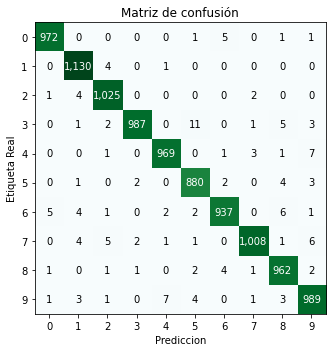

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
prediccion=np.concatenate(prediccion)
correcto=np.concatenate(correcto)
def plot_cl(cm, labels, cmap=plt.cm.BuGn):
  fig, ax = plt.subplots(figsize=(5,5), tight_layout=True)
  ax.imshow(cm, interpolation='nearest',cmap=cmap)
  for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
      ax.text(j,i,"{:,}".format(cm[i,j]), horizontalalignment="center", verticalalignment="center",color="white" if cm[i,j]> np.amax(cm)/2 else "black")
  ax.set_title("Matriz de confusión")
  tick_marks=np.arange(len(labels))
  plt.xticks(tick_marks,labels)
  plt.yticks(tick_marks,labels)
  plt.ylabel("Etiqueta Real")
  plt.xlabel("Prediccion")

cm=confusion_matrix(correcto, prediccion)
plot_cl(cm,labels=[str(i) for i in range(10)])
print(classification_report(correcto,prediccion,digits=3))

**Imprimir 10 predicciones a partir de datos de prueba**

In [120]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [121]:
actual_number = lbls[:10].numpy()
actual_number

array([0, 5, 8, 6, 1, 2, 5, 9, 7, 0])

In [123]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Numero de prediccion: {pred_y}')
print(f'Numero correcto: {actual_number}')

Numero de prediccion: [0 5 8 6 1 2 5 9 7 0]
Numero correcto: [0 5 8 6 1 2 5 9 7 0]
